## Homework 2: Rebekah Dix

#### John Stachurski

OSM 2018

### Exercise 1

Write your own version of a one dimensional [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation), which estimates a density from a sample.

Write it as a class that takes the data $X$ and bandwidth $h$ when initialized and provides a method $f$ such that

$$
    f(x) = \frac{1}{hn} \sum_{i=1}^n 
    K \left( \frac{x-X_i}{h} \right)
$$

For $K$ use the Gaussian kernel ($K$ is the standard normal density).

Write the class so that the bandwidth defaults to Silverman's rule (see the "rule of thumb" discussion on [this page](https://en.wikipedia.org/wiki/Kernel_density_estimation)).  Test the class you have written by going through the steps

1. simulate data $X_1, \ldots, X_n$ from distribution $\phi$
2. plot the kernel density estimate over a suitable range
2. plot the density of $\phi$ on the same figure

for distributions $\phi$ of the following types


* [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with $\alpha = \beta = 2$
* [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with $\alpha = 2$ and $\beta = 5$
* [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with $\alpha = \beta = 0.5$

Use $n=100$.

Make a comment on your results.  (Do you think this is a good estimator of these distributions?)

In [4]:
# import statements
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import beta
from numba import jit, njit, prange

In [5]:
class kernal_DE():
    """
    This class is a one dimensional kernal density estimator.
    
    Attributes:
        data (array): this array contains the observed data
        bandwidth (float): the bandwidth with which to calculate the kernal density estimate,
                           defaults to silverman's rule of thumb if not specified
        n (int): number of observations
    """
    
    # Constructor
    def __init__(self, X, h=None):
        self.data = X
        self.n = len(X)
        
        if h is None:
            self.bandwidth = self.silverman()
        else:
            self.bandwidth = h
        
    def kde(self, x):
        """This function estimates the density at the point x."""
        
        estimate = 0
        for ii, point in enumerate(self.data):
            estimate += norm.pdf( (x - point) / self.bandwidth )
        
        estimate = estimate * (1 / (self.n * self.bandwidth))
        
        return estimate
        
    def silverman(self):
        """Calculate bandwidth by Silverman's rule of thumb."""

        # sample standard deviation
        σ = np.std(self.data)
        bandwidth = (1.06) * σ * (self.n ** -.2)
    
        return bandwidth   
        

### Simulate from distributions

In [21]:
# draw data from each distribution
n = 100
d1 = beta.rvs(2, 2, size=n)
d2 = beta.rvs(2, 5, size=n)
d3 = beta.rvs(.5, .5, size=n)

In [22]:
# create kernal density estimation objects
kernald1 = kernal_DE(d1)
kernald2 = kernal_DE(d2)
kernald3 = kernal_DE(d3)

In [23]:
# define domain
x = np.linspace(0, 1, 100)

In [24]:
d1estimate, d2estimate, d3estimate = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)

# estimate kernal densities 
for ind, xx in enumerate(x):
    d1estimate[ind] = kernald1.kde(xx)
    d2estimate[ind] = kernald2.kde(xx)
    d3estimate[ind] = kernald3.kde(xx)

### Plot Kernal Density Estimtate and True Distribution

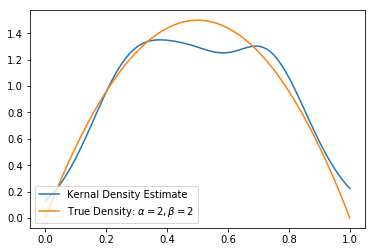

In [25]:
plt.plot(x, d1estimate, label='Kernal Density Estimate')
plt.plot(x, beta.pdf(x, 2, 2), label=r'True Density: $\alpha = 2, \beta = 2$')
plt.legend(loc=3)
plt.show()

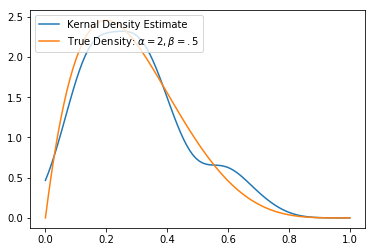

In [26]:
plt.plot(x, d2estimate, label='Kernal Density Estimate')
plt.plot(x, beta.pdf(x, 2, 5), label=r'True Density: $\alpha = 2, \beta = .5$')
plt.legend(loc=2)
plt.show()

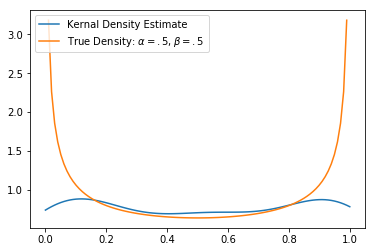

In [27]:
plt.plot(x, d3estimate, label='Kernal Density Estimate')
plt.plot(x, beta.pdf(x, .5, .5), label=r'True Density: $\alpha = .5, \beta = .5$')
plt.legend(loc=2)
plt.show()

### Exercise 2

In class we discussed the following fact:  For the $AR(1)$ process

$$ X_{t+1} = \rho X_t + b + \sigma \xi_{t+1} $$

with $\{ \xi_t \}$ iid and standard normal, 

$$ 
    \psi_t = N(\mu, s^2) \implies \psi_{t+1} 
    = N(\rho \mu + b, \rho^2 s^2 + \sigma^2) 
$$

Confirm this, at least approximately, by simulation.  Let

* $\rho = 0.9$
* $b = 0.0$
* $\sigma = 0.1$
* $\mu = -3$
* $s = 0.2$

First, plot $\psi_t$ and $\psi_{t+1}$ using the true distributions described above.

Second, plot $\psi_{t+1}$ on the same figure (in a different color) as follows:

1. Generate $n$ draws of $X_t$ from the $N(\mu, s^2)$ distribution
2. Update them all using the rule $X_{t+1} = \rho X_t + b + \sigma \xi_{t+1}$
3. Use the resulting sample of $X_{t+1}$ values to produce a density estimate via kernel density estimation.

Try this for several different values of $n$ and confirm that the simulation based estimate of $\psi_{t+1}$ does converge to the theoretical distribution.

In [34]:
# define parameters
ρ = .9
b = 0
σ = .1
μ = -3
s = .2

def simulate_process(n):
    
    # plt ψ_t and ψ_{t+1}
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    x = np.linspace(-5, -1, n)
    ax.plot(x, norm.pdf(x, μ, s),'r-', alpha=0.6, label=r'$N(\mu, s^2)$')
    ax.plot(x, norm.pdf(x, ρ*μ +b, np.sqrt((ρ **2) * (s ** 2) + σ **2)), alpha=0.6, label=r'$N(\rho\mu + b, \rho^2 s^2 + \sigma^2)$')
    
    # approximate distribution ψ_{t+1}
    # generate n draws
    xt = norm.rvs(μ, s, size=n)
    xt1 = np.empty_like(x)
    for ii in range(len(x)):
        xt1[ii] = ρ * xt[ii] + b + σ * norm.rvs()

    kernalNorm = kernal_DE(xt1) 
    normEstimate = np.zeros_like(x)
    for ind, xx in enumerate(x):
        normEstimate[ind] = kernalNorm.kde(xx)

    ax.plot(x, normEstimate, label='Kernal Density Estimate')
    plt.title("Number of iterations = %i" %n)
    plt.legend()
    plt.show()

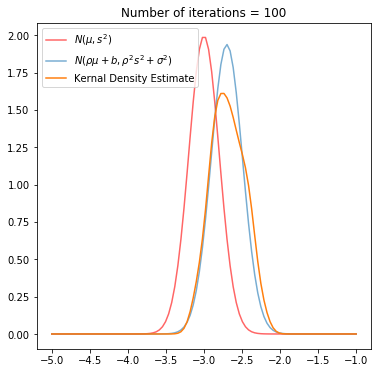

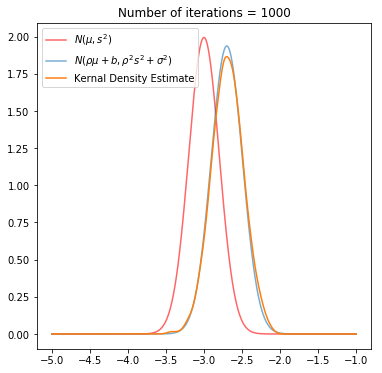

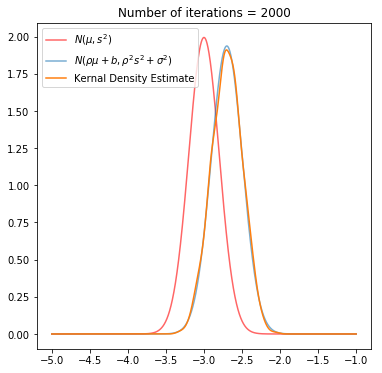

In [35]:
simulate_process(100)
simulate_process(1000)
simulate_process(2000)

### Exercise 3

In the lecture it was claimed that, for $n \times n$ matrix $A$, we have

$$ r(A) < 1 \implies A^k \to 0 $$

where convergence is in terms of the spectral norm.  

Prove this using Gelfand's formula.

#### Proof

Observe that $A^k \to 0$ if and only if $||A^k - 0|| \to 0$ if and only if $||A^k|| \to 0$. Therefore, we will show that the spectral norm of $A^k$ converges to 0 as $k \to \infty$. 

Let $\epsilon$ be such that $0< \epsilon < 1 - r(A)$. By Gelfand's formula, there exists a $K \in \mathbb{N}$ such that for all $k \geq K$, $| ||A^k||^{\frac{1}{k}} - r(A)| < \epsilon$. This can be written as,

\begin{equation}
    (r(A) - \epsilon)^k < ||A^k|| < (r(A) + \epsilon) ^k
\end{equation}

Observe that $||A^k|| \geq 0$, which implies that, 
\begin{equation}
    0 \leq ||A^k|| < (r(A) + \epsilon) ^k
\end{equation}

Now, $r(A) + \epsilon < 1$. Thus, $(r(A) + \epsilon) ^k \to 0$ as  $k \to \infty$. Therefore, $||A^k|| \to 0$ as $k \to \infty$, so $A^k$  converges to 0 as $k \to \infty$. 